In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from FUN import * # Fichier de fonctions

# Fonctions

In [ ]:
def load_image(filename):
    """
    Importation de l'image, passage en nuance de gris, puis passage dans [0,1]
    """
    my_img = Image.open(filename)
    img_gray = ImageOps.grayscale(my_img)
    img_gray = np.array(img_gray)
    img_gray_binary = np.where(img_gray > 0.5, 1, 0) #Passage en binaire
    return img_gray_binary


In [ ]:
def tograyscale(mat):
    """
    Scale les nombres de la matrice dans [0,255] (pour permettre les images en nuance de gris)
    Mais ne prend pas encore en compte le négatif
    """
    scaled_mat = 255.0*mat/mat.max()
    return scaled_mat

In [ ]:
def noise(img, TAU, MU):
    """
    Ajout d'un bruit gaussien aux pixels de l'image
    """
    img_noised = np.zeros(shape = img.shape)
    row, col = np.shape(img)
    for i in range(row):
        for j in range(col):
            # ATTENTION: scale c'est l'écart type 
            img_noised[i,j] = np.random.normal(loc = MU[int(img[i,j])], scale = TAU)
    
    return img_noised

In [ ]:
def create_noised_image(img, name, TAU, MU = [0,1]):
    """
    img = chemin vers l'image à bruiter
    name = suffixe de l'image bruitée enregistrée
    TAU = écart-type pour le bruit gaussien
    MU = moyenne pour le bruit gaussien MU[0] = 0, MU[1] = 1 par défaut donc bruit centré
    """
    
    
    img_bin = load_image(img)
    img_bin_noised = noise(img_bin, TAU, MU)
    plt.imshow(img_bin_noised, cmap = "gray")
    
    tosave = Image.fromarray(tograyscale(img_bin_noised))
    tosave.convert("L").save("data/"+str(name)+"_"+str(TAU)+".png")

In [ ]:
def sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU):
    """
    Echantillonne dans la distribution conditionnelle selon la formule que j'ai calculée
    """
   
    # Ajout des valeurs des 4 voisins du pixel considéré, si pertinent
    voisins = []
    if i != 0:
        voisins.append(X[i-1][j])
    if i!= maxi-1:
        voisins.append(X[i+1][j])
    if j!= 0:
        voisins.append(X[i][j-1])
    if j!= maxj-1:
        voisins.append(X[i][j+1])
        
    # Calcul du nombre de 0 et de 1 dans les voisins
    nb_0 = sum(voisins[i] == 0 for i in range(len(voisins)))
    nb_1 = sum(voisins[i] == 1 for i in range(len(voisins)))
    
    # Prise en considération de la variation du nombre de voisins (bords)
    pond = 4/len(voisins) 
    
    # Calcul de la probabilité de valoir 1
    exp_valeur_1 = -ALPHA + BETA * pond * (nb_0-nb_1) + 1/(2*(TAU**2))*(MU[1]**2 - MU[0]**2 + 2*Y[i][j]*(MU[0]-MU[1]))
    # Calcul de la probabilité de valoir 0 (juste pour vérifier)
    exp_valeur_0 = ALPHA + BETA * pond * (nb_1-nb_0) + 1/(2*(TAU**2))*(MU[0]**2 - MU[1]**2 + 2*Y[i][j]*(MU[1]-MU[0]))
    
    #print(1/(1+np.exp(exp_valeur_1)) + 1/(1+np.exp(exp_valeur_0)))
    #print(1/(1+np.exp(exp_valeur_0)))
    
    prob = 1/(1+np.exp(exp_valeur_1))
    
    return(int(np.random.rand() < prob)) # Renvoie 1 si l'uniforme est inférieure à la proba de valoir 1

In [ ]:
    def get_posterior(filename, burn_in, samples, ALPHA, BETA, TAU, MU = [0,1]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    """
    Y = load_image(filename) # Chargement de l'image
    plt.imshow(Y, cmap = "gray") # Affichage de l'image bruitée
    plt.show()

    posterior = np.zeros(Y.shape)
    X = np.random.choice([1,0], size = Y.shape) #Initialisation de la sortie
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    
    for step in tqdm(range(burn_in + samples)):
        
        # Ici on boucle de manière déterministe, idéalement il faudrait le faire de manière aléatoire
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On fait la moyenne
    posterior = posterior / samples

    return posterior

In [ ]:
def denoise_image(filename, burn_in, samples, ALPHA, BETA, TAU, MU = [0,1]):
    """
    Ici on considère comme 1 valant 1 les pixels où le posterior 
    vaut 1 à une fréquence supérieure à seuil
    mu = [0,1] par défaut donc pas de biais
    """
    
    posterior = get_posterior(filename, burn_in, samples, ALPHA, BETA, TAU, MU)
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior > 0.5] = 1 # POur passer des probas à des valeurs 
    
    return denoised

In [ ]:
og_image = Image.open("data/poke.png")
plt.imshow(og_image, cmap = "gray")
og_image.close()

# Exemple de création d'une image bruitée 

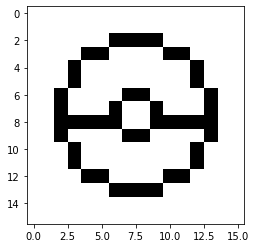

In [2]:
create_noised_image("data/poke.png", "bis", TAU = 0)

# Tentative de débruitage

In [ ]:
posterior = get_posterior("data/poke_noise.png", 1000, 1000)

In [ ]:
posterior = get_posterior("data/poke_noise_01_0point1.png", 1000, 1000, ALPHA = 0.2, BETA = 0.2, TAU = 0.1)

In [ ]:
plt.imshow(posterior, cmap = "gray")